<a href="https://colab.research.google.com/github/Kprerak-iisc/data-science/blob/master/cred_bal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
!ls /content/gdrive/'My Drive/Colab Notebooks/credit_balance'

cred_bal.ipynb	data


In [4]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
%matplotlib inline

col_list = ['#005f9a', '#00CDCD', '#f1bdbf']
sns.set_palette(col_list)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [9]:
credit_df = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/credit_balance/data/Credit.csv', index_col=0)

In [10]:
credit_df.head()

,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Ethnicity,Balance
1,14.891,3606,283,2,34,11,Male,No,Yes,Caucasian,333
2,106.025,6645,483,3,82,15,Female,Yes,Yes,Asian,903
3,104.593,7075,514,4,71,11,Male,No,No,Asian,580
4,148.924,9504,681,3,36,11,Female,No,No,Asian,964
5,55.882,4897,357,2,68,16,Male,No,Yes,Caucasian,331


In [11]:
credit_df.count()

Income       400
Limit        400
Rating       400
Cards        400
Age          400
Education    400
Gender       400
Student      400
Married      400
Ethnicity    400
Balance      400
dtype: int64

Categorical variable processing

In [12]:
credit_df.Gender = credit_df.Gender.astype('category')
credit_df.Student = credit_df.Student.astype('category')
credit_df.Married = credit_df.Married.astype('category')
credit_df.Ethnicity = credit_df.Ethnicity.astype('category')

In [13]:
credit_df.describe()

,Income,Limit,Rating,Cards,Age,Education,Balance
count,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000
mean,45.218885,4735.600000,354.940000,2.957500,55.667500,13.450000,520.015000
std,35.244273,2308.198848,154.724143,1.371275,17.249807,3.125207,459.758877
min,10.354000,855.000000,93.000000,1.000000,23.000000,5.000000,0.000000
25%,21.007250,3088.000000,247.250000,2.000000,41.750000,11.000000,68.750000
50%,33.115500,4622.500000,344.000000,3.000000,56.000000,14.000000,459.500000
75%,57.470750,5872.750000,437.250000,4.000000,70.000000,16.000000,863.000000
max,186.634000,13913.000000,982.000000,9.000000,98.000000,20.000000,1999.000000


In [14]:
credit_df.describe(include=['category'])

,Gender,Student,Married,Ethnicity
count,400,400,400,400
unique,2,2,2,3
top,Female,No,Yes,Caucasian
freq,207,360,245,199


**Exploratory Data Analysis**

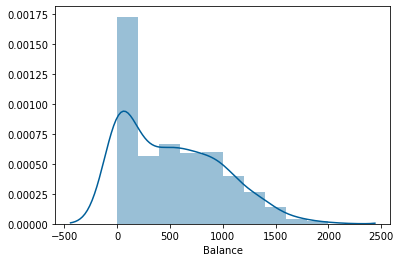

In [15]:
sns.distplot(credit_df.Balance)

It can be noticed that a large portion of the sample consists of Zero Balance Cards. if the average credit card Balance for a given individual is zero, we conclude that the person does not make use of that credit card. As a credit card company, we may be interested in knowing the average balance across our frequent users.
Additional data frame containaining the observations with a positive Balance.

In [16]:
active_credit_df = credit_df.loc[credit_df.Balance>0,].copy()
active_credit_df.Balance.describe() 

count     310.000000
mean      670.987097
std       413.904019
min         5.000000
25%       338.000000
50%       637.500000
75%       960.750000
max      1999.000000
Name: Balance, dtype: float64

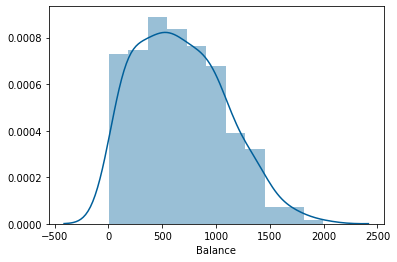

In [17]:
sns.distplot(active_credit_df.Balance)

Without the zero Balances, the curve resembles a normal distribution. 
A new variable can be added to the original data frame which specifies whether an individual is a regular user of their credit card (i.e. whether they have a positive Balance).

In [18]:
credit_df['Active'] = np.where(credit_df['Balance']>0, 'Yes', 'No')  
credit_df.Active.describe()

count     400
unique      2
top       Yes
freq      310
Name: Active, dtype: object

([<matplotlib.axis.YTick at 0x7fd80882c438>,
 [Text(0, 0, 'Income'),
  Text(0, 0, 'Limit'),
  Text(0, 0, 'Rating'),
  Text(0, 0, 'Cards'),
  Text(0, 0, 'Age'),
  Text(0, 0, 'Education'),
  Text(0, 0, 'Balance')])

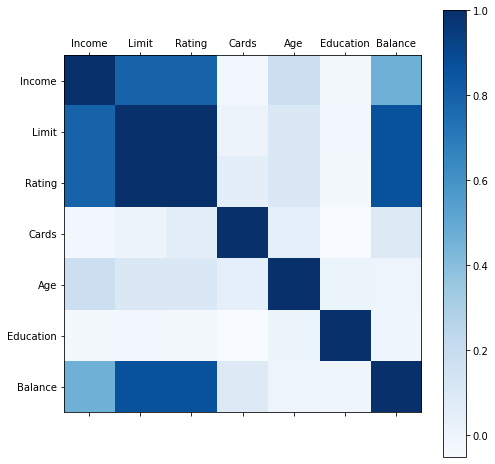

In [19]:
numeric_credit_df = credit_df.select_dtypes(include=['int64', 'float64'])
plt.figure(figsize=(8,8))
plt.matshow(credit_df.corr(), cmap=plt.cm.Blues, fignum=1)
plt.colorbar()
tick_marks = [i for i in range(len(numeric_credit_df.columns))]
plt.xticks(tick_marks, numeric_credit_df.columns)
plt.yticks(tick_marks, numeric_credit_df.columns)

Based on the correlation matrix, Balance appears correlated with Limit, Rating, and moderately correlated with Income. In addition, Limit and Rating are highly correlated with each other, and they both have a relationship with Income.

However, this matrix does not confirm whether the correlation coefficients are statistically significant, hence further investigation is necessary.

In [20]:
from scipy.stats import pearsonr
r1, p1 = pearsonr(credit_df.Balance, credit_df.Limit)
msg = "Correlation coefficient Balance-Limit: {}\n p-value: {}\n"
print(msg.format(r1, p1))
r2, p2 = pearsonr(credit_df.Balance, credit_df.Rating)
msg = "Correlation coefficient Balance-Rating: {}\n p-value: {}\n"
print(msg.format(r2, p2))
r3, p3 = pearsonr(credit_df.Balance, credit_df.Income)
msg = "Correlation coefficient Balance-Income: {}\n p-value: {}\n"
print(msg.format(r3, p3))
r4, p4 = pearsonr(credit_df.Limit, credit_df.Rating)
msg = "Correlation coefficient Limit-Rating: {}\n p-value: {}\n"
print(msg.format(r4, p4))
r5, p5 = pearsonr(credit_df.Limit, credit_df.Income)
msg = "Correlation coefficient Limit-Income: {}\n p-value: {}\n"
print(msg.format(r5, p5))
r6, p6 = pearsonr(credit_df.Rating, credit_df.Income)
msg = "Correlation coefficient Rating-Income: {}\n p-value: {}\n"
print(msg.format(r6, p6))

Correlation coefficient Balance-Limit: 0.8616972670153953
 p-value: 2.5305807117131246e-119

Correlation coefficient Balance-Rating: 0.8636251606214953
 p-value: 1.8988990970393693e-120

Correlation coefficient Balance-Income: 0.46365645701575736
 p-value: 1.0308858025891003e-22

Correlation coefficient Limit-Rating: 0.9968797370016829
 p-value: 0.0

Correlation coefficient Limit-Income: 0.7920883413369415
 p-value: 2.3917894422844805e-87

Correlation coefficient Rating-Income: 0.7913776251121218
 p-value: 4.362691443088444e-87



All the relationships are significant. Additionally Limit and Rating have a remarkably high correlation coefficient.

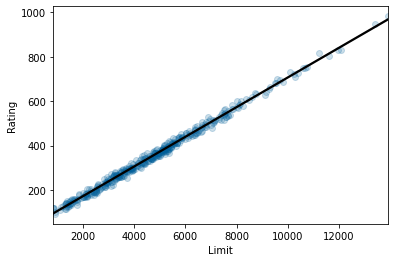

In [21]:
sns.regplot(x='Limit',
           y='Rating',
           data=credit_df,
           scatter_kws={'alpha':0.2},
           line_kws={'color':'black'})

Limit and Rating are highly correlated, introducing multi-colinearity in the model. More specifically, Rating as an antecedent of Limit is more meaningful for the model because it also drives Limit levels for card owners. Therefore, if one of the two should be removed to fix collinearity issues, Limit has a lower priority for the model.
For clarity, the analysis will focus less on Rating and Limit, and more on those measures representing more direct indicators of credit profiling.

We will now examine the categorical variables and their relationship to balance.

Ethnicity
African American    AxesSubplot(0.555556,0.125;0.344444x0.328261)
Asian               AxesSubplot(0.555556,0.125;0.344444x0.328261)
Caucasian           AxesSubplot(0.555556,0.125;0.344444x0.328261)
Name: Balance, dtype: object

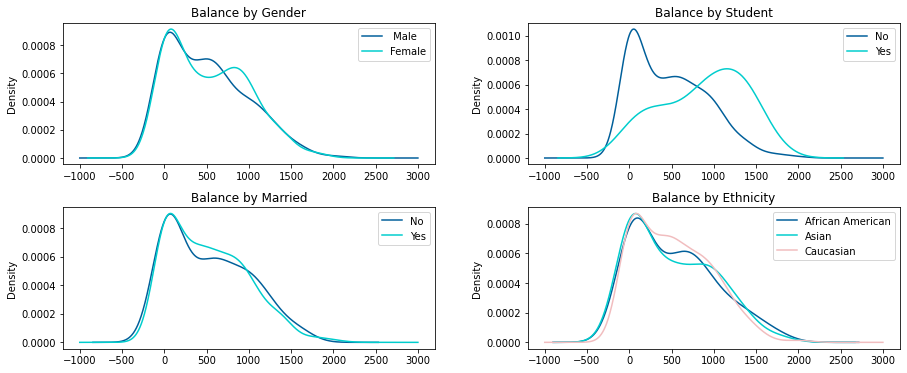

In [22]:
f, axes = plt.subplots(2, 2, figsize=(15, 6))
f.subplots_adjust(hspace=.3, wspace=.25)
credit_df.groupby('Gender').Balance.plot(kind='kde', ax=axes[0][0], legend=True, title='Balance by Gender')
credit_df.groupby('Student').Balance.plot(kind='kde', ax=axes[0][1], legend=True, title='Balance by Student')
credit_df.groupby('Married').Balance.plot(kind='kde', ax=axes[1][0], legend=True, title='Balance by Married')
credit_df.groupby('Ethnicity').Balance.plot(kind='kde', ax=axes[1][1], legend=True, title='Balance by Ethnicity')

Student appears to be the only predictor to influence the distribution of Balance. To verify, the same relationships can be analyzed on the active-only sample of the population

Ethnicity
African American    AxesSubplot(0.555556,0.125;0.344444x0.328261)
Asian               AxesSubplot(0.555556,0.125;0.344444x0.328261)
Caucasian           AxesSubplot(0.555556,0.125;0.344444x0.328261)
Name: Balance, dtype: object

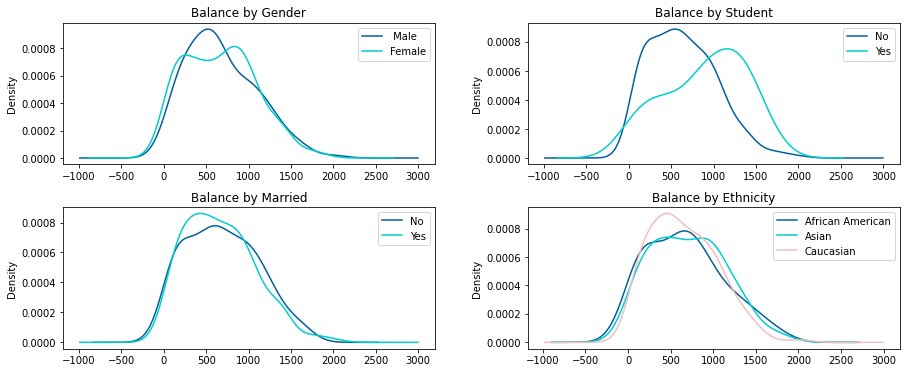

In [23]:
f, axes = plt.subplots(2, 2, figsize=(15, 6))
f.subplots_adjust(hspace=.3, wspace=.25)
active_credit_df.groupby('Gender').Balance.plot(kind='kde', ax=axes[0][0], legend=True, title='Balance by Gender')
active_credit_df.groupby('Student').Balance.plot(kind='kde', ax=axes[0][1], legend=True, title='Balance by Student')
active_credit_df.groupby('Married').Balance.plot(kind='kde', ax=axes[1][0], legend=True, title='Balance by Married')
active_credit_df.groupby('Ethnicity').Balance.plot(kind='kde', ax=axes[1][1], legend=True, title='Balance by Ethnicity')

Although the variables Gender, Married, and Ethnicity do not appear associated with Balance when observed in isolation, their interaction with one another might make them valuable. This will be investigated at a later point in the analysis.

The Student variable should be closely examined at this point.

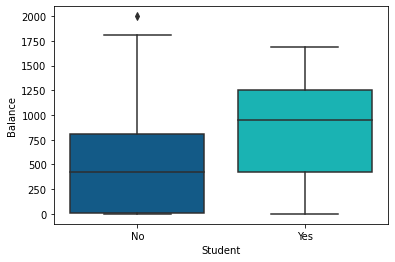

In [24]:
sns.boxplot(x='Student', y='Balance', data = credit_df)

Students display on average higher credit card Balances. We infer that Students have a higher need for financing due to student loans and have generally lower personal income 

**Multivariable Regression Model**

After visually examining the predictors and their relationship with Balance, regression models can be fit using those predictors. feature selection will be used to determine which combination of variables best predicts credit card Balance.

Given the choice of 9 predictors, the initial model could include all of them. Yet, as previously noted, due to potential collinearity issues, Limit will be eliminated.

In [25]:
mod0 = smf.ols('Balance ~ Income + Rating + Cards + Age + Education + Gender + Student + Married + Ethnicity', data = credit_df).fit()
mod0.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Balance   R-squared:                       0.951
Model:                            OLS   Adj. R-squared:                  0.950
Method:                 Least Squares   F-statistic:                     757.8
Date:                Tue, 18 Aug 2020   Prob (F-statistic):          4.46e-248
Time:                        14:54:16   Log-Likelihood:                -2415.4
No. Observations:                 400   AIC:                             4853.
Df Residuals:                     389   BIC:                             4897.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept               -549.3140     35.085    -15.657      0.000    -618.293    -480.335
Gender[T.Female]         -10.7106     10.325     -1.037      0.300     -31.010       9.589
Student[T.Yes]           416.4376     17.336     24.021      0.000     382.353     450.522
Married[T.Yes]           -15.1096     10.728     -1.408      0.160     -36.202       5.983
Ethnicity[T.Asian]        21.7616     14.678      1.483      0.139      -7.096      50.619
Ethnicity[T.Caucasian]    10.6492     12.716      0.837      0.403     -14.351      35.649
Income                    -7.7746      0.244    -31.878      0.000      -8.254      -7.295
Rating                     3.9790      0.055     72.332      0.000       3.871       4.087
Cards                      3.9654      3.793      1.045      0.296      -3.492      11.422
Age                       -0.6416      0.306     -2.096      0.037      -1.243      -0.040
Education                 -0.3799      1.659     -0.229      0.819      -3.642       2.882
==============================================================================
Omnibus:                       15.651   Durbin-Watson:                   1.987
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               16.769
Skew:                           0.490   Prob(JB):                     0.000228
Kurtosis:                       2.789   Cond. No.                     2.73e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.73e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Income is negatively related to balance which could be interpreted in the sense that the higher the Income, the lower the need to access loans.

Student has an expected positive impact. Similarly, these results are consistent with Age. This variable reveals that with Age, the credit card Balance decreases which corroborate the notion that people become more in charge of their finances over time.

Surprisingly, the years of Education do not have a significant impact on the credit card Balance. Other variables with no impact are Cards, Ethnicity, Gender and Married.

We fit the same model on our reduced dataset of only active customers.

In [26]:
active_mod0 = smf.ols('Balance ~ Income + Rating + Cards + Age + Education + Gender + Student + Married + Ethnicity', data = active_credit_df).fit()
active_mod0.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Balance   R-squared:                       0.985
Model:                            OLS   Adj. R-squared:                  0.984
Method:                 Least Squares   F-statistic:                     1918.
Date:                Tue, 18 Aug 2020   Prob (F-statistic):          1.38e-264
Time:                        14:55:21   Log-Likelihood:                -1659.9
No. Observations:                 310   AIC:                             3342.
Df Residuals:                     299   BIC:                             3383.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept               -791.3689     21.193    -37.340      0.000    -833.076    -749.662
Gender[T.Female]          -2.6107      5.961     -0.438      0.662     -14.341       9.119
Student[T.Yes]           478.1566      9.239     51.752      0.000     459.974     496.339
Married[T.Yes]           -14.0808      6.221     -2.263      0.024     -26.324      -1.837
Ethnicity[T.Asian]         4.1786      8.590      0.486      0.627     -12.726      21.083
Ethnicity[T.Caucasian]    -1.8990      7.284     -0.261      0.794     -16.233      12.435
Income                    -9.7126      0.145    -66.859      0.000      -9.999      -9.427
Rating                     4.7767      0.040    120.602      0.000       4.699       4.855
Cards                      3.0923      2.102      1.471      0.142      -1.045       7.229
Age                       -1.1431      0.176     -6.481      0.000      -1.490      -0.796
Education                  1.2817      0.938      1.366      0.173      -0.564       3.128
==============================================================================
Omnibus:                        2.652   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.265   Jarque-Bera (JB):                2.433
Skew:                          -0.139   Prob(JB):                        0.296
Kurtosis:                       2.666   Cond. No.                     3.14e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.14e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The model has a superior fit for the Active customers dataset. This points to the hypothesis that perhaps the non-active customers are driven by some reason other than the ones present in our variables. Since they rarely make use of their credit card, it is difficult to draw conclusions. Perhaps they, in fact, have credit card debt, yet we do not have the relevant data, potentially their credit card is provided by a different company. An alternative explanation could be that the card owners maintain a zero-balance card in order to decrease their credit utilization and boost their credit rating, assuming they also own a positive balance credit card elsewhere.

We could exclude the variables which yield a high p-value from the model. Nevertheless, these variables could have an interaction with other variables and might still be significant.

We continue by fitting a model with only the variables that proved significant, yet as part of the analysis, we will return to examining the other variables.

In [27]:
mod1 = smf.ols('Balance ~ Income + Rating + Age + Student', data = credit_df).fit()
mod1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Balance   R-squared:                       0.950
Model:                            OLS   Adj. R-squared:                  0.950
Method:                 Least Squares   F-statistic:                     1892.
Date:                Tue, 18 Aug 2020   Prob (F-statistic):          4.17e-256
Time:                        14:56:03   Log-Likelihood:                -2418.6
No. Observations:                 400   AIC:                             4847.
Df Residuals:                     395   BIC:                             4867.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       -547.3047     21.461    -25.503      0.000    -589.496    -505.113
Student[T.Yes]   417.5056     17.172     24.314      0.000     383.746     451.265
Income            -7.7977      0.242    -32.198      0.000      -8.274      -7.322
Rating             3.9807      0.055     72.927      0.000       3.873       4.088
Age               -0.6242      0.304     -2.053      0.041      -1.222      -0.026
==============================================================================
Omnibus:                       15.838   Durbin-Watson:                   1.953
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               17.000
Skew:                           0.494   Prob(JB):                     0.000203
Kurtosis:                       2.793   Cond. No.                     1.66e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.66e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Now all the variables are significant, but the R-squared has, in fact, decreased.

The potential relationships among these 4 variables should be analyzed.

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


Student
No     AxesSubplot(0.555556,0.125;0.344444x0.18875)
Yes    AxesSubplot(0.555556,0.125;0.344444x0.18875)
Name: Age, dtype: object

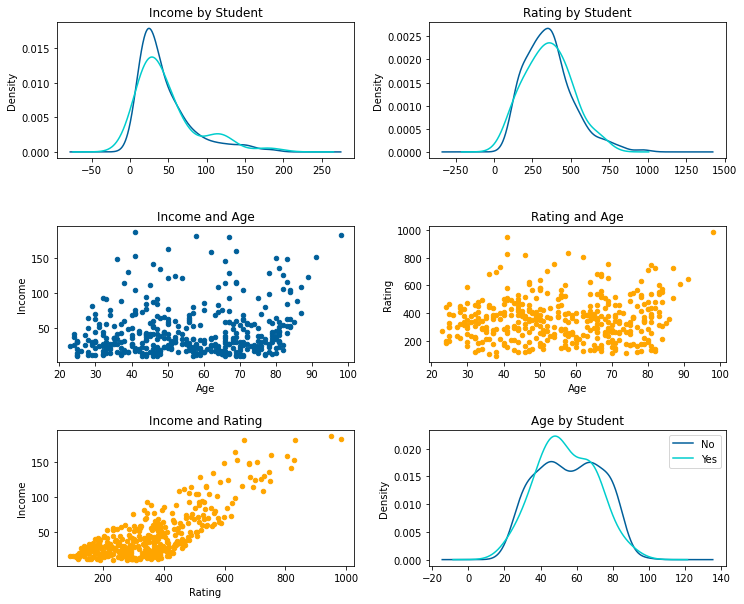

In [28]:
f, axes = plt.subplots(3, 2, figsize=(12, 10))
f.subplots_adjust(hspace=.5, wspace=.25)
credit_df.groupby('Student').Income.plot(kind='kde', ax=axes[0][0], title='Income by Student')
credit_df.groupby('Student').Rating.plot(kind='kde', ax=axes[0][1], title='Rating by Student')
credit_df.plot(kind='scatter', x='Age' , y='Income' , ax=axes[1][0], title='Income and Age')
credit_df.plot(kind='scatter', x='Age' , y='Rating' , ax=axes[1][1], color='orange', title='Rating and Age')
credit_df.plot(kind='scatter', x='Rating' , y='Income' , ax=axes[2][0], color='orange', title='Income and Rating')
credit_df.groupby('Student').Age.plot(kind='kde', ax=axes[2][1], legend=True, title='Age by Student')

As expected, we notice a positive relationship between Income and Rating. This could be explained by the fact that credit Rating is a score assigned to individuals based on their creditworthiness, including the level of personal Income.

Furthermore, as we predicted earlier, Students display lower values of Income compared to non-Students.

Surprisingly, in this dataset, the Income does not Increase with Age, and the Age of Students compared to non-Students does not differ significantly. This observation could lead us to be concerned about the data quality or to seek further attributes of this population to conduct additional investigation. Nonetheless, given the simulated nature of this dataset additional inquiries are not feasible, yet it is worth noting that on a different population, we expect a stronger relationship among Age, Student, and Income.

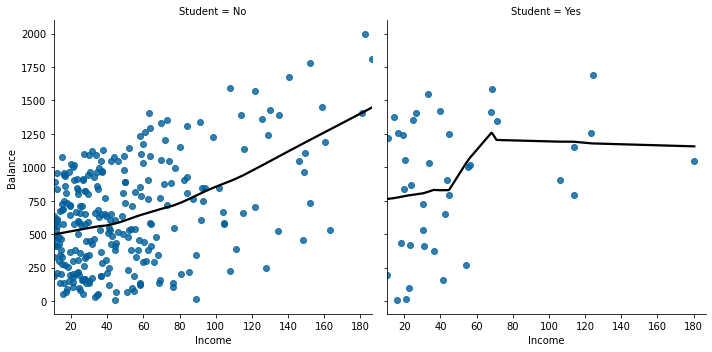

In [29]:
sns.lmplot(x='Income',
          y='Balance',
          data=active_credit_df,
          line_kws={'color':'black'},
          lowess=True,
          col='Student')

We observe a positive relationship between Balance and Income for non-Students, however, in the case of Students, changes in Income do not impact their average credit card Balance. A further step would be to fit a regression model on non-Students only and observe Balance. For Students, the line appears to behave differently in 3 sections, so perhaps a Spline model might be appropriate. However, the sample size of Students is not large enough (no. of observations = 40) for the results to add significant value to the overall analysis.

An interesting observation is that the regression analysis showed that Income was negatively related to Balance, yet this figure appears to show a positive relationship. We should verify whether the relationship is in fact non-linear.

**Non-linear Relationships**

In [30]:
mod2 = smf.ols('Balance ~ Income + I(Income**2) + Age + Student + Rating', data = credit_df).fit()
mod2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Balance   R-squared:                       0.951
Model:                            OLS   Adj. R-squared:                  0.950
Method:                 Least Squares   F-statistic:                     1524.
Date:                Tue, 18 Aug 2020   Prob (F-statistic):          3.68e-255
Time:                        14:59:21   Log-Likelihood:                -2416.9
No. Observations:                 400   AIC:                             4846.
Df Residuals:                     394   BIC:                             4870.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       -527.6722     23.950    -22.032      0.000    -574.757    -480.587
Student[T.Yes]   416.9706     17.124     24.350      0.000     383.305     450.636
Income            -8.6268      0.514    -16.768      0.000      -9.638      -7.615
I(Income ** 2)     0.0055      0.003      1.825      0.069      -0.000       0.011
Age               -0.6161      0.303     -2.032      0.043      -1.212      -0.020
Rating             3.9790      0.054     73.098      0.000       3.872       4.086
==============================================================================
Omnibus:                       14.185   Durbin-Watson:                   1.954
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               14.920
Skew:                           0.456   Prob(JB):                     0.000576
Kurtosis:                       2.748   Cond. No.                     3.05e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.05e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The model has improved and the non-linear term is marginally significant. Additionally, while Income has a negative impact on Balance, Income squared has a slightly positive impact. We expect Balance to have a negative slope initially, and a positive one at higher levels of Income. We can plot this relationship.

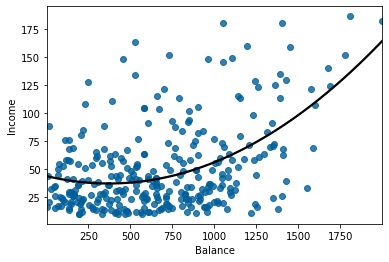

In [31]:
sns.regplot('Balance', 'Income',
           data = active_credit_df,
           ci=None,
           order=2,
           line_kws={'color':'black'})

As anticipated, at lower levels of Income, increases in personal Income cause a decrease in credit card Balance, which can be interpreted as individuals requiring less financing as they make use of personal finances instead of credit debt.

However, at high levels of income, Balance increases, meaning that those individuals are in higher need of loans, potentially due to increased investment activities and a greater risk tolerance.

**Interactions Between Predictors**

An interaction term could be considered between Income and Rating. This stems from the assumption that there could be a synergy between Income and Rating

In [32]:
mod3 = smf.ols('Balance ~ Income + I(Income**2) + Age + Student + Income*Rating', data = credit_df).fit()
mod3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Balance   R-squared:                       0.957
Model:                            OLS   Adj. R-squared:                  0.956
Method:                 Least Squares   F-statistic:                     1458.
Date:                Tue, 18 Aug 2020   Prob (F-statistic):          5.13e-265
Time:                        15:02:42   Log-Likelihood:                -2390.0
No. Observations:                 400   AIC:                             4794.
Df Residuals:                     393   BIC:                             4822.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       -429.1239     25.969    -16.524      0.000    -480.180    -378.068
Student[T.Yes]   425.7135     16.073     26.487      0.000     394.114     457.313
Income            -9.0837      0.485    -18.712      0.000     -10.038      -8.129
I(Income ** 2)    -0.0329      0.006     -5.638      0.000      -0.044      -0.021
Age               -0.6821      0.284     -2.402      0.017      -1.240      -0.124
Rating             3.4940      0.082     42.515      0.000       3.332       3.656
Income:Rating      0.0110      0.001      7.521      0.000       0.008       0.014
==============================================================================
Omnibus:                        7.324   Durbin-Watson:                   1.967
Prob(Omnibus):                  0.026   Jarque-Bera (JB):                6.374
Skew:                           0.237   Prob(JB):                       0.0413
Kurtosis:                       2.604   Cond. No.                     1.85e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.85e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The Adjusted R-squared increased and the interaction term is statistically significant.

We could examine how the variables that were originally removed interact with other variables, such as for example years spent in Education and personal Income.

In [33]:
mod4 = smf.ols('Balance ~ Income + I(Income**2) + Rating + Age + Student + Education*Income', data = credit_df).fit()
mod4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Balance   R-squared:                       0.951
Model:                            OLS   Adj. R-squared:                  0.951
Method:                 Least Squares   F-statistic:                     1096.
Date:                Tue, 18 Aug 2020   Prob (F-statistic):          5.89e-253
Time:                        15:03:11   Log-Likelihood:                -2414.6
No. Observations:                 400   AIC:                             4845.
Df Residuals:                     392   BIC:                             4877.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         -455.5497     44.548    -10.226      0.000    -543.133    -367.966
Student[T.Yes]     416.8402     17.116     24.354      0.000     383.189     450.491
Income              -9.9373      0.807    -12.308      0.000     -11.525      -8.350
I(Income ** 2)       0.0060      0.003      1.977      0.049    3.17e-05       0.012
Rating               3.9711      0.054     73.019      0.000       3.864       4.078
Age                 -0.6240      0.302     -2.064      0.040      -1.218      -0.030
Education           -5.0695      2.673     -1.897      0.059     -10.324       0.185
Education:Income     0.0943      0.045      2.091      0.037       0.006       0.183
==============================================================================
Omnibus:                       13.655   Durbin-Watson:                   1.959
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               14.400
Skew:                           0.450   Prob(JB):                     0.000747
Kurtosis:                       2.771   Cond. No.                     5.70e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.7e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Interestingly, while education did not appear significant at first, it does interact with Income, with a positive effect. Moreover, in this model Education itself seems marginally significant, meaning that the longer the time spent in education, the lower the Balance and the more financially cautious an individual is. Yet the effect reverses at high levels of Income and Education were highly educated high earning individuals appear to have higher needs for financing.

Let us consider further interactions, such as the one between Married and Age.

In [34]:
mod5 = smf.ols('Balance ~ Income + I(Income**2) + Rating + Age + Student + Married*Age', data = credit_df).fit()
mod5.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Balance   R-squared:                       0.952
Model:                            OLS   Adj. R-squared:                  0.951
Method:                 Least Squares   F-statistic:                     1101.
Date:                Tue, 18 Aug 2020   Prob (F-statistic):          2.35e-253
Time:                        15:03:45   Log-Likelihood:                -2413.6
No. Observations:                 400   AIC:                             4843.
Df Residuals:                     392   BIC:                             4875.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept           -561.6504     32.973    -17.033      0.000    -626.477    -496.823
Student[T.Yes]       417.3806     17.121     24.378      0.000     383.720     451.041
Married[T.Yes]        58.2726     35.992      1.619      0.106     -12.489     129.035
Income                -8.6631      0.512    -16.924      0.000      -9.670      -7.657
I(Income ** 2)         0.0059      0.003      1.949      0.052   -5.12e-05       0.012
Rating                 3.9786      0.054     73.496      0.000       3.872       4.085
Age                    0.1420      0.481      0.295      0.768      -0.804       1.088
Married[T.Yes]:Age    -1.2944      0.611     -2.118      0.035      -2.496      -0.093
==============================================================================
Omnibus:                       12.889   Durbin-Watson:                   1.958
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               13.569
Skew:                           0.438   Prob(JB):                      0.00113
Kurtosis:                       2.786   Cond. No.                     5.73e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.73e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

While neither Married nor Age by themselves are significant, the interaction term is. This reveals the fact that individuals with higher values for Age who are also Married have lower credit card Balances pointing to higher financial prudence or risk aversion. We can visualize this relationship.

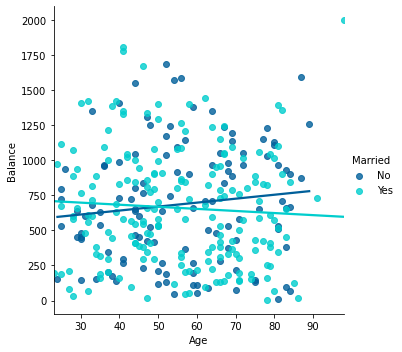

In [35]:
sns.lmplot(x="Age", 
           y="Balance", 
           hue="Married", 
           ci=None,
           data=active_credit_df);

In [36]:
mod6 = smf.ols('Balance ~ Income + I(Income**2) + Rating + Age + Student + Gender*Cards', data = credit_df).fit()
mod6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Balance   R-squared:                       0.952
Model:                            OLS   Adj. R-squared:                  0.951
Method:                 Least Squares   F-statistic:                     961.4
Date:                Tue, 18 Aug 2020   Prob (F-statistic):          7.75e-252
Time:                        15:04:47   Log-Likelihood:                -2413.6
No. Observations:                 400   AIC:                             4845.
Df Residuals:                     391   BIC:                             4881.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept               -505.5063     29.280    -17.264      0.000    -563.073    -447.939
Student[T.Yes]           414.7916     17.165     24.165      0.000     381.045     448.538
Gender[T.Female]         -56.9505     24.573     -2.318      0.021    -105.262      -8.639
Income                    -8.6253      0.514    -16.766      0.000      -9.637      -7.614
I(Income ** 2)             0.0058      0.003      1.932      0.054      -0.000       0.012
Rating                     3.9674      0.055     72.561      0.000       3.860       4.075
Age                       -0.6826      0.303     -2.250      0.025      -1.279      -0.086
Cards                     -3.2603      5.083     -0.641      0.522     -13.254       6.734
Gender[T.Female]:Cards    15.7543      7.584      2.077      0.038       0.843      30.666
==============================================================================
Omnibus:                       13.489   Durbin-Watson:                   1.972
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               14.150
Skew:                           0.444   Prob(JB):                     0.000846
Kurtosis:                       2.755   Cond. No.                     4.30e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.3e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

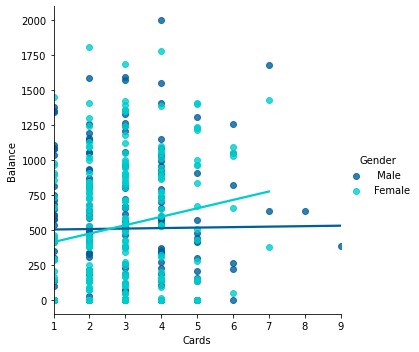

In [37]:
sns.lmplot(x="Cards", 
           y="Balance", 
           hue="Gender", 
           ci=None,
           data = credit_df);

The interaction between Gender and Cards is significant with a high coefficient, which demonstrates that Females who own more Cards have on average higher Balance. In this dataset we make the assumption that the Balance is recorded per person and not per credit card, implying that the balance recorded is calculated as an average across all the cards belonging to the same individual. While owning more credit Cards suggests in itself higher financing needs (perhaps the multiple cards offer different benefits), the relation with Gender is worth noting. We should also mention the fact that Gender in isolation has a negative impact on Balance, suggesting that females, in general, have less credit card debt, except when that individual also owns multiple Cards.

**Finding the Best Model**

After investigating polynomial relationships and interaction among terms, the last part of the analysis will focus on finding the best model and using it to predict credit card Balance for a generated sample of individuals. The purpose of this exercise is to employ the model and make inferences on the target variable, given a set of predictors. In other words, if an individual applies for a credit card, this model will predict an average credit card balance given the demographic factors (i.e. Income, Age, Rating). The information can be further utilized to estimate the risk of credit default or other customer behavior indicators of the given card owner.

For this part of the analysis, we will focus separately on the active and non-active samples of the population.

The best performing model so far on the entire sample included a polynomial relationship between Income and Balance and an interaction term between Income and Rating.

In [38]:
active_mod7 = smf.ols('Balance ~ Income + I(Income**2) + Rating + Age + Student + Income*Rating', 
                      data = active_credit_df).fit()
active_mod7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Balance   R-squared:                       0.984
Model:                            OLS   Adj. R-squared:                  0.984
Method:                 Least Squares   F-statistic:                     3170.
Date:                Tue, 18 Aug 2020   Prob (F-statistic):          4.43e-270
Time:                        15:07:31   Log-Likelihood:                -1663.2
No. Observations:                 310   AIC:                             3340.
Df Residuals:                     303   BIC:                             3367.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       -780.4994     20.847    -37.439      0.000    -821.523    -739.475
Student[T.Yes]   482.1976      9.149     52.705      0.000     464.194     500.201
Income            -9.4049      0.290    -32.466      0.000      -9.975      -8.835
I(Income ** 2)    -0.0045      0.003     -1.333      0.184      -0.011       0.002
Rating             4.7559      0.066     72.197      0.000       4.626       4.886
Age               -1.1266      0.177     -6.374      0.000      -1.474      -0.779
Income:Rating      0.0006      0.001      0.658      0.511      -0.001       0.002
==============================================================================
Omnibus:                        2.411   Durbin-Watson:                   1.956
Prob(Omnibus):                  0.300   Jarque-Bera (JB):                2.335
Skew:                          -0.152   Prob(JB):                        0.311
Kurtosis:                       2.703   Cond. No.                     2.72e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.72e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In the case of the active user population, neither non-linear relationships nor interaction among variables displayed low p-values. Nevertheless, other variables might explain the variance in Balance, such as Limit or Cards.

In [39]:
active_mod8 = smf.ols('Balance ~ Limit + Rating + Income + Age + Student + Cards', data = active_credit_df).fit()
active_mod8.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Balance   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 8.031e+04
Date:                Tue, 18 Aug 2020   Prob (F-statistic):               0.00
Time:                        15:08:00   Log-Likelihood:                -1164.6
No. Observations:                 310   AIC:                             2343.
Df Residuals:                     303   BIC:                             2369.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       -698.5009      3.294   -212.053      0.000    -704.983    -692.019
Student[T.Yes]   501.0420      1.843    271.823      0.000     497.415     504.669
Limit              0.3365      0.004     85.333      0.000       0.329       0.344
Rating            -0.1501      0.058     -2.574      0.011      -0.265      -0.035
Income            -9.9930      0.029   -340.893      0.000     -10.051      -9.935
Age               -1.0000      0.035    -28.260      0.000      -1.070      -0.930
Cards             25.5015      0.497     51.278      0.000      24.523      26.480
==============================================================================
Omnibus:                        3.568   Durbin-Watson:                   2.067
Prob(Omnibus):                  0.168   Jarque-Bera (JB):                3.625
Skew:                          -0.258   Prob(JB):                        0.163
Kurtosis:                       2.882   Cond. No.                     3.27e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.27e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

This is the best model so far, with an R-squared of 99%. Adding the Limit term seems to have had a strong impact. This is a relationship which can be further analyzed.

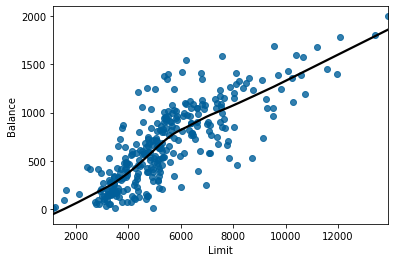

In [40]:
sns.regplot(x='Limit',
          y='Balance',
          data=active_credit_df,
          line_kws={'color':'black'},
          lowess=True)

Credit Limit appears to be a strong predictor for credit card Balance. This is an expected finding since we assume that a card owner is not allowed to have a Balance that exceeds their Limit. Consequently, this relationship simply articulates that, the higher the credit Limit, the greater the credit card expenses are for a given individual, and hence the insightfulness of this relationship is debatable.

In [41]:
mod9 = smf.ols('Balance ~ Rating', data = credit_df).fit()
mod9.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Balance   R-squared:                       0.746
Model:                            OLS   Adj. R-squared:                  0.745
Method:                 Least Squares   F-statistic:                     1168.
Date:                Tue, 18 Aug 2020   Prob (F-statistic):          1.90e-120
Time:                        15:08:59   Log-Likelihood:                -2745.4
No. Observations:                 400   AIC:                             5495.
Df Residuals:                     398   BIC:                             5503.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -390.8463     29.069    -13.446      0.000    -447.993    -333.699
Rating         2.5662      0.075     34.176      0.000       2.419       2.714
==============================================================================
Omnibus:                       23.223   Durbin-Watson:                   1.966
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               38.802
Skew:                           0.390   Prob(JB):                     3.75e-09
Kurtosis:                       4.311   Cond. No.                         970.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Similarly, credit Rating is a highly accurate predictor of Balance. This could suggest that individuals with high Rating are more willing to incur credit debt as they are confident that they will be able to pay off the balance. Nevertheless, Rating is a complex variable, related to other predictors such as Income.

For the entire dataset, the best model predicted 96% of the variance, while the model fit on the active-only population predicted 99%. The difference suggests that there are other factors influencing non-active cardholders which are not present in our data, or their spending behaviour is reflected on other lending platforms.

**Logistic Regression**

In order to determine the factors that influence whether a card owner is an active credit card user, a logistic regression can be fit.

In [42]:
log_mod = smf.glm('Active ~ Limit + Rating + Income + Age + Cards + Education', 
                   data = credit_df,
                   family=sm.families.Binomial()).fit()
log_mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Generalized Linear Model Regression Results                       
=========================================================================================
Dep. Variable:     ['Active[No]', 'Active[Yes]']   No. Observations:                  400
Model:                                       GLM   Df Residuals:                      393
Model Family:                           Binomial   Df Model:                            6
Link Function:                             logit   Scale:                          1.0000
Method:                                     IRLS   Log-Likelihood:                -53.379
Date:                           Tue, 18 Aug 2020   Deviance:                       106.76
Time:                                   15:10:41   Pearson chi2:                     464.
No. Iterations:                                9                                         
Covariance Type:                       nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      8.3924      2.040      4.114      0.000       4.394      12.390
Limit         -0.0024      0.002     -1.368      0.171      -0.006       0.001
Rating        -0.0210      0.026     -0.792      0.429      -0.073       0.031
Income         0.1114      0.021      5.291      0.000       0.070       0.153
Age           -0.0021      0.015     -0.143      0.886      -0.031       0.027
Cards         -0.1709      0.256     -0.668      0.504      -0.673       0.331
Education      0.0444      0.088      0.503      0.615      -0.128       0.217
==============================================================================
"""

The results unveil that Income is the only statistically significant predictor of whether the card owner is active or not, high earners having a greater probability of being active. This could be explained by low earners maintaining a zero-balance card in order to boost their creditworthiness.

**Making Predictions**

In [43]:
df_new=pd.DataFrame({'Income':np.random.normal(45, 20, 40),
                    'Rating':np.random.normal(355, 55, 40),
                    'Limit':np.random.normal(4735, 200, 40),
                    'Age':np.random.normal(56, 17, 40),
                    'Cards':list(range(0,10))*4,
                    'Student':['Yes']*20+['No']*20})
df_new.Cards[df_new.Cards == 0] = 3
df_new.Income[df_new.Income <= 0] = df_new.Income.mean()
df_new.Rating[df_new.Rating <= 0] = df_new.Rating.mean()
df_new.Limit[df_new.Limit <= 0] = df_new.Limit.mean()
df_new['Balance']= active_mod8.predict(df_new)
df_new.describe()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: Setti

,Income,Rating,Limit,Age,Cards,Balance
count,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000
mean,44.327085,358.215193,4672.072575,58.281705,4.800000,691.581966
std,20.946226,58.108786,201.661363,18.833286,2.554032,311.468968
min,10.709182,197.935312,4049.488381,15.181698,1.000000,-5.384491
25%,24.727313,314.401064,4544.164992,44.332195,3.000000,472.084131
50%,44.611602,368.098979,4708.224625,62.622048,4.500000,754.682790
75%,57.696347,399.181783,4799.698700,71.697393,7.000000,888.685187
max,84.560433,441.075656,5191.172230,89.729448,9.000000,1261.020772


In [44]:
mod8 = smf.ols('Balance ~ Income + I(Income**2) + Age + Student + Income*Rating + Limit + Cards', data = credit_df).fit()
mod8.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Balance   R-squared:                       0.962
Model:                            OLS   Adj. R-squared:                  0.961
Method:                 Least Squares   F-statistic:                     1221.
Date:                Tue, 18 Aug 2020   Prob (F-statistic):          3.04e-271
Time:                        15:12:40   Log-Likelihood:                -2367.9
No. Observations:                 400   AIC:                             4754.
Df Residuals:                     391   BIC:                             4790.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       -368.0046     28.204    -13.048      0.000    -423.455    -312.554
Student[T.Yes]   433.8736     15.294     28.368      0.000     403.804     463.943
Income            -9.3145      0.464    -20.074      0.000     -10.227      -8.402
I(Income ** 2)    -0.0313      0.006     -5.633      0.000      -0.042      -0.020
Age               -0.6784      0.270     -2.514      0.012      -1.209      -0.148
Rating             0.5141      0.454      1.133      0.258      -0.378       1.406
Income:Rating      0.0109      0.001      7.903      0.000       0.008       0.014
Limit              0.1998      0.030      6.650      0.000       0.141       0.259
Cards             18.5345      3.991      4.644      0.000      10.688      26.381
==============================================================================
Omnibus:                       11.908   Durbin-Watson:                   1.961
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               12.521
Skew:                           0.432   Prob(JB):                      0.00191
Kurtosis:                       2.932   Cond. No.                     2.14e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.14e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""